In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import penn
import torch
import torchaudio

import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Local checkpoint to use
# If None, Huggingface will be used unless a checkpoint is given in the CLI
ppgs.LOCAL_CHECKPOINT = f'/repos/ppgs/runs/w2v2fb/00200000.pt'

### Load audio

In [4]:
# stems = promonet.load.partition('vctk')['valid']
# stem = stems[47]
# promonet.load.text(promonet.CACHE_DIR / 'vctk' / f'{stem}.txt')
audio = promonet.load.audio('/hemera-storage1/pardo/max/test-audio/ill-be-back.wav')[:, :-int(.17 * promonet.SAMPLE_RATE)]
ipd.Audio(audio, rate=promonet.SAMPLE_RATE)

In [8]:
import penn

def pitch_track(audio, threshold):
    return penn.from_audio(
        audio,
        sample_rate=promonet.SAMPLE_RATE,
        hopsize=promonet.convert.samples_to_seconds(promonet.HOPSIZE),
        fmin=promonet.FMIN,
        fmax=promonet.FMAX,
        batch_size=2048,
        center='half-hop',
        decoder='argmax',
        interp_unvoiced_at=threshold,
        gpu=0)[0]

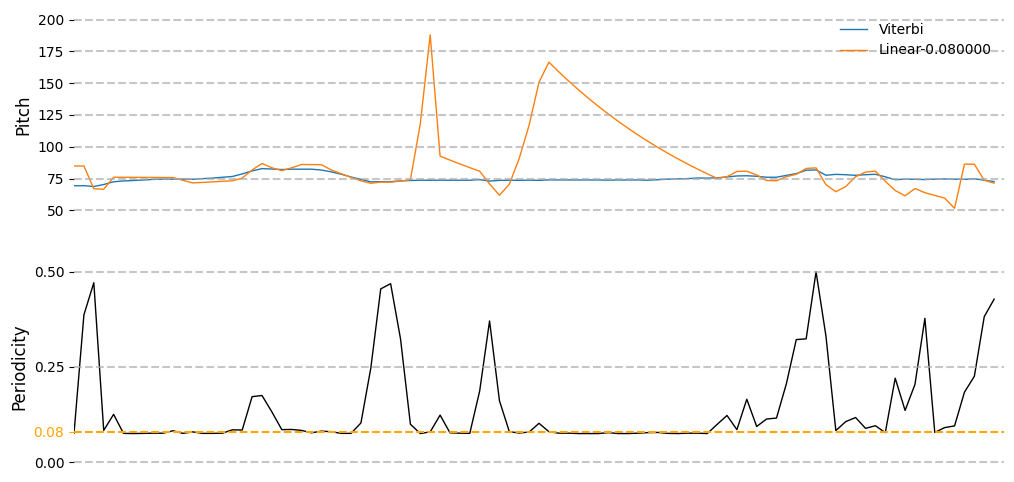

In [9]:
# threshold = 0
threshold = .08
# threshold = .1
# threshold = .15
# threshold = .2

key = 'Argmax' if threshold == 0 else f'Linear-{threshold:03f}'
pitches = {
    'Viterbi': pitch.cpu().squeeze(),
    key: pitch_track(audio, threshold).cpu().squeeze()
}

figure, axes = plt.subplots(2, 1, figsize=(12, 6))
for k, p in pitches.items():
    axes[0].plot(p.squeeze().cpu(), linewidth=1., label=k)
axes[0].legend(frameon=False)
ymin = min(min(val) for val in pitches.values())
ymax = max(max(val) for val in pitches.values())
axes[0].set_xmargin(0.)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].set_xticks([])
ymin = ymin // 25 * 25
ymax = (ymax + 25) // 25 * 25
ystep = 25 if (ymax - ymin <= 150) else 50
yticks = torch.arange(ymin, ymax + ystep, ystep)
axes[0].set_yticks(yticks)
for tick in yticks:
    axes[0].hlines(tick, xmin=0., xmax=pitch.shape[-1], color='#aaaa', linestyle='--')
axes[0].set_ylabel('Pitch', fontsize=12)

axes[1].plot(periodicity.squeeze().cpu(), color='black', linewidth=1.)
ymin = periodicity.min()
ymax = periodicity.max()
axes[1].set_xmargin(0.)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].set_xticks([])
ymin = ymin // .25 * .25
ymax = (ymax + .25) // .25 * .25
ystep = .25
yticks = set(torch.arange(ymin, ymax + ystep, ystep).tolist())
yticks.add(threshold)
yticks = list(yticks)
tickobjs = axes[1].set_yticks(yticks)
for tick in yticks:
    color = 'orange' if tick == threshold else '#aaaa'
    axes[1].hlines(tick, xmin=0., xmax=periodicity.shape[-1], color=color, linestyle='--')
idx = yticks.index(threshold)
axes[1].get_yticklabels()[idx].set_color('orange')
tickobjs[idx]._apply_params(color='orange')
axes[1].set_ylabel('Periodicity', fontsize=12)
plt.savefig(f'viterbi-{threshold:03f}.png', bbox_inches='tight', pad_inches=0, transparent=True)